In [1]:
"""
PROJECT 4: STATE-LEVEL MATERNAL MORTALITY ANALYSIS (2018-2024)

Author: Marshawn Shelton, MPH, PMP, CCMP
Date: November 13, 2025
Part of: OE-3PI Framework Research Program

Research Questions:
1. Which states have worst maternal mortality?
2. Which states have biggest disparities?
3. Did 2023-2024 show improvement from 2021 peak?
4. Which states recovered fastest post-COVID?
5. Do policies correlate with outcomes?

This analysis will validate the OE-3PI Framework hypothesis:
States with operational infrastructure will show better outcomes
than states with policy coverage alone.
"""

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# New visualization tools
import plotly.express as px
import plotly.graph_objects as go

# Import reusable functions from Project 2
import sys
sys.path.append('/Users/marshawnshelton/Documents/equity-metrics-dashboard')
from src.analysis import (
    load_maternal_data, 
    load_birth_data, 
    create_race_ethnicity,
    calculate_mmr,
    create_disparity_ratios,
    visualize_disparities
)

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ All imports successful!")
print("✅ Ready to download and analyze 2023-2024 data!")

✅ All imports successful!
✅ Ready to download and analyze 2023-2024 data!


In [2]:
# Load the state-level data (2018-2023)
print("=" * 80)
print("LOADING 2018-2023 STATE-LEVEL DATA")
print("This includes 2023 - our first look at post-policy outcomes!")
print("=" * 80)

# Use absolute paths to be sure
base_path = '/Users/marshawnshelton/Documents/equity-metrics-dashboard'

mortality_state = load_maternal_data(f'{base_path}/data/raw/maternal_mortality_state_2018_2023.txt')
births_state = load_birth_data(f'{base_path}/data/raw/births_state_2018_2023.txt')

print(f"\n📊 DATA SUMMARY:")
print(f"{'='*60}")
print(f"States in dataset: {mortality_state['State'].nunique()}")
print(f"Years available: {sorted(mortality_state['Year'].unique())}")
print(f"Total deaths 2018-2023: {mortality_state['Deaths'].sum():,.0f}")
print(f"Total births 2018-2023: {births_state['Births'].sum():,.0f}")

# Check for 2023 data specifically
deaths_2023 = mortality_state[mortality_state['Year'] == 2023]['Deaths'].sum()
births_2023 = births_state[births_state['Year'] == 2023]['Births'].sum()

print(f"\n🎯 2023 SPECIFIC DATA (Post-Medicaid Extension):")
print(f"{'='*60}")
print(f"2023 Deaths: {deaths_2023:,.0f}")
print(f"2023 Births: {births_2023:,.0f}")

# Quick peek at the data structure
print(f"\n📋 Sample of mortality data:")
print(mortality_state.head(10))

LOADING 2018-2023 STATE-LEVEL DATA
This includes 2023 - our first look at post-policy outcomes!
✅ Loaded 5,661 rows of maternal mortality data
✅ Loaded 7,381 rows of birth data
   Total births: 22,077,525

📊 DATA SUMMARY:
States in dataset: 51
Years available: [np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0), np.float64(nan)]
Total deaths 2018-2023: 5,121
Total births 2018-2023: 22,077,525

🎯 2023 SPECIFIC DATA (Post-Medicaid Extension):
2023 Deaths: 679
2023 Births: 3,595,470

📋 Sample of mortality data:
  Notes    State  State Code    Year  Year Code         Hispanic Origin  \
0   NaN  Alabama         1.0  2018.0     2018.0      Hispanic or Latino   
1   NaN  Alabama         1.0  2018.0     2018.0      Hispanic or Latino   
2   NaN  Alabama         1.0  2018.0     2018.0      Hispanic or Latino   
3   NaN  Alabama         1.0  2018.0     2018.0      Hispanic or Latino   
4   NaN  Alabama         1.0  2018.0     20

In [3]:
# Standardize race/ethnicity categories
print("Standardizing race/ethnicity categories...")

mortality_state['race_ethnicity'] = mortality_state.apply(create_race_ethnicity, axis=1)
births_state['race_ethnicity'] = births_state.apply(create_race_ethnicity, axis=1)

# Clean the data - remove any rows with missing Year
mortality_state = mortality_state[mortality_state['Year'].notna()].copy()
births_state = births_state[births_state['Year'].notna()].copy()

print("✅ Race/ethnicity standardized")
print(f"✅ Data cleaned")

# Verify race/ethnicity categories
print(f"\n📋 Race/Ethnicity Categories:")
print(mortality_state['race_ethnicity'].value_counts())

# Verify years
print(f"\n📅 Years in dataset:")
print(sorted(mortality_state['Year'].unique()))

Standardizing race/ethnicity categories...
✅ Race/ethnicity standardized
✅ Data cleaned

📋 Race/Ethnicity Categories:
race_ethnicity
Other/Unknown         3686
Hispanic or Latino    1901
Name: count, dtype: int64

📅 Years in dataset:
[np.float64(2018.0), np.float64(2019.0), np.float64(2020.0), np.float64(2021.0), np.float64(2022.0), np.float64(2023.0)]


In [4]:
# Check what the State column is actually called
print("Mortality data columns:")
print([col for col in mortality_state.columns if 'state' in col.lower()])

print("\nBirth data columns:")
print([col for col in births_state.columns if 'state' in col.lower()])

Mortality data columns:
['State', 'State Code']

Birth data columns:
['State of Residence', 'State of Residence Code']


In [5]:
# Rename births column to match mortality data
births_state = births_state.rename(columns={'State of Residence': 'State'})

print("✅ Column names standardized!")
print(f"\nMortality columns: {[col for col in mortality_state.columns if 'State' in col]}")
print(f"Birth columns: {[col for col in births_state.columns if 'State' in col]}")

✅ Column names standardized!

Mortality columns: ['State', 'State Code']
Birth columns: ['State', 'State of Residence Code']


In [6]:
# Calculate state-level MMRs (overall, all races combined)
print("=" * 80)
print("CALCULATING STATE-LEVEL MATERNAL MORTALITY RATES")
print("=" * 80)

state_mmr_overall = calculate_mmr(
    mortality_state,
    births_state,
    group_by=['State']
)

print(f"\n🏆 TOP 10 BEST STATES (Lowest MMR 2018-2023):")
print("=" * 60)
print(state_mmr_overall.head(10)[['State', 'Deaths', 'Births', 'MMR']])

print(f"\n⚠️  TOP 10 WORST STATES (Highest MMR 2018-2023):")
print("=" * 60)
print(state_mmr_overall.tail(10)[['State', 'Deaths', 'Births', 'MMR']])

CALCULATING STATE-LEVEL MATERNAL MORTALITY RATES
✅ Calculated MMR for 51 groups
   Total deaths: 5,121
   Total births: 22,077,525

🏆 TOP 10 BEST STATES (Lowest MMR 2018-2023):
            State  Deaths     Births        MMR
0         Alabama   169.0   348033.0  48.558614
1       Tennessee   229.0   486847.0  47.037365
2         Georgia   344.0   750288.0  45.849061
3  North Carolina   294.0   716438.0  41.036349
4       Louisiana   133.0   344713.0  38.582821
5           Texas   800.0  2275653.0  35.154745
6        Kentucky   110.0   315139.0  34.905232
7     Mississippi    72.0   213303.0  33.754800
8        Virginia   192.0   576086.0  33.328357
9            Ohio   247.0   783661.0  31.518731

⚠️  TOP 10 WORST STATES (Highest MMR 2018-2023):
                   State  Deaths    Births  MMR
41                Nevada     0.0  203041.0  0.0
42              Nebraska     0.0  147556.0  0.0
43               Montana     0.0   66748.0  0.0
44                Alaska     0.0   57021.0  0.0
45  D

In [7]:
# Let's look at the data more carefully
print("Checking for data quality issues...\n")

# How many states have zero deaths?
zero_death_states = state_mmr_overall[state_mmr_overall['Deaths'] == 0]
print(f"States with 0 deaths (likely suppressed data): {len(zero_death_states)}")
print(zero_death_states['State'].tolist())

# Show states with actual data
valid_states = state_mmr_overall[state_mmr_overall['Deaths'] > 0].copy()
print(f"\nStates with valid data: {len(valid_states)}")

# Re-sort to see actual best and worst
print(f"\n🏆 TOP 10 BEST STATES (Lowest MMR - Valid Data Only):")
print("=" * 60)
print(valid_states.nsmallest(10, 'MMR')[['State', 'Deaths', 'Births', 'MMR']])

print(f"\n⚠️  TOP 10 WORST STATES (Highest MMR - Valid Data Only):")
print("=" * 60)
print(valid_states.nlargest(10, 'MMR')[['State', 'Deaths', 'Births', 'MMR']])

Checking for data quality issues...

States with 0 deaths (likely suppressed data): 17
['South Dakota', 'Vermont', 'Rhode Island', 'Delaware', 'North Dakota', 'Connecticut', 'New Hampshire', 'Nevada', 'Nebraska', 'Montana', 'Alaska', 'District of Columbia', 'Maine', 'Hawaii', 'Idaho', 'Kansas', 'Wyoming']

States with valid data: 34

🏆 TOP 10 BEST STATES (Lowest MMR - Valid Data Only):
            State  Deaths    Births        MMR
33      Minnesota    13.0  386921.0   3.359859
32       Colorado    13.0  374055.0   3.475425
31           Utah    10.0  277178.0   3.607790
30       Oklahoma    12.0  291119.0   4.122026
29  Massachusetts    21.0  409426.0   5.129132
28           Iowa    14.0  220914.0   6.337308
27     New Mexico    10.0  131766.0   7.589211
26  West Virginia    10.0  104311.0   9.586717
25      Wisconsin    36.0  369452.0   9.744162
24     Washington    53.0  502242.0  10.552682

⚠️  TOP 10 WORST STATES (Highest MMR - Valid Data Only):
            State  Deaths     Births

In [8]:
# Compare 2021 (peak) vs 2023 (post-policy)
print("=" * 80)
print("COMPARING COVID PEAK (2021) vs POST-POLICY (2023)")
print("=" * 80)

# Calculate MMR by year
mmr_by_year = calculate_mmr(
    mortality_state,
    births_state,
    group_by=['Year']
)

print("\n📊 National MMR by Year:")
print(mmr_by_year[['Year', 'Deaths', 'Births', 'MMR']])

# Calculate percent change 2021 → 2023
mmr_2021 = mmr_by_year[mmr_by_year['Year'] == 2021]['MMR'].values[0]
mmr_2023 = mmr_by_year[mmr_by_year['Year'] == 2023]['MMR'].values[0]
pct_change = ((mmr_2023 - mmr_2021) / mmr_2021) * 100

print(f"\n🎯 KEY FINDING:")
print(f"2021 (Peak): {mmr_2021:.1f} per 100K")
print(f"2023 (Post-Policy): {mmr_2023:.1f} per 100K")
print(f"Change: {pct_change:+.1f}%")

if pct_change < 0:
    print(f"✅ IMPROVEMENT of {abs(pct_change):.1f}%")
else:
    print(f"⚠️  INCREASE of {pct_change:.1f}%")

COMPARING COVID PEAK (2021) vs POST-POLICY (2023)
✅ Calculated MMR for 6 groups
   Total deaths: 5,121
   Total births: 22,077,525

📊 National MMR by Year:
     Year  Deaths     Births        MMR
0  2021.0  1260.0  3663729.0  34.391190
1  2020.0   917.0  3613047.0  25.380240
2  2022.0   886.0  3667193.0  24.160168
3  2019.0   730.0  3746972.0  19.482398
4  2023.0   679.0  3595470.0  18.884875
5  2018.0   649.0  3791114.0  17.118979

🎯 KEY FINDING:
2021 (Peak): 34.4 per 100K
2023 (Post-Policy): 18.9 per 100K
Change: -45.1%
✅ IMPROVEMENT of 45.1%


In [9]:
# Calculate state MMR by year to see who recovered best
print("=" * 80)
print("STATE RECOVERY ANALYSIS: 2021 → 2023")
print("=" * 80)

# Calculate MMR by state and year
state_year_mmr = calculate_mmr(
    mortality_state,
    births_state,
    group_by=['State', 'Year']
)

# Get 2021 and 2023 data for each state
mmr_2021 = state_year_mmr[state_year_mmr['Year'] == 2021][['State', 'MMR']].rename(columns={'MMR': 'MMR_2021'})
mmr_2023 = state_year_mmr[state_year_mmr['Year'] == 2023][['State', 'MMR']].rename(columns={'MMR': 'MMR_2023'})

# Merge
state_change = mmr_2021.merge(mmr_2023, on='State', how='inner')

# Calculate change
state_change['Change'] = state_change['MMR_2023'] - state_change['MMR_2021']
state_change['Pct_Change'] = (state_change['Change'] / state_change['MMR_2021']) * 100

# Remove states with zero (suppressed data)
state_change = state_change[(state_change['MMR_2021'] > 0) & (state_change['MMR_2023'] > 0)]

# Sort by improvement
state_change_sorted = state_change.sort_values('Pct_Change')

print(f"\n🏆 TOP 10 STATES WITH BIGGEST IMPROVEMENT (2021 → 2023):")
print("=" * 70)
print(state_change_sorted.head(10).to_string(index=False))

print(f"\n⚠️  TOP 10 STATES WITH WORST PERFORMANCE (2021 → 2023):")
print("=" * 70)
print(state_change_sorted.tail(10).to_string(index=False))

print(f"\n📊 National average improvement: -45.1%")

STATE RECOVERY ANALYSIS: 2021 → 2023
✅ Calculated MMR for 306 groups
   Total deaths: 5,121
   Total births: 22,077,525

🏆 TOP 10 STATES WITH BIGGEST IMPROVEMENT (2021 → 2023):
      State  MMR_2021  MMR_2023     Change  Pct_Change
    Alabama 77.524722 24.200100 -53.324622  -68.784022
 New Jersey 39.411973 13.861386 -25.550587  -64.829505
  Louisiana 71.382558 30.955242 -40.427316  -56.634725
       Ohio 47.002258 22.854441 -24.147817  -51.375866
   Virginia 53.224796 25.905338 -27.319459  -51.328442
   Michigan 28.577688 15.133172 -13.444517  -47.045500
   Arkansas 52.846772 28.369599 -24.477173  -46.317253
Mississippi 62.603153 34.833091 -27.770061  -44.358886
      Texas 54.339097 30.416761 -23.922336  -44.024169
    Florida 44.854039 26.197165 -18.656874  -41.594635

⚠️  TOP 10 STATES WITH WORST PERFORMANCE (2021 → 2023):
         State  MMR_2021  MMR_2023     Change  Pct_Change
    California 21.397596 12.996491  -8.401105  -39.261910
     Tennessee 68.539257 42.161563 -26.377694

In [10]:
# Save the state-level analysis
print("Saving state-level data for Project 5 analysis...")

# Save overall state MMRs
state_mmr_overall.to_csv(f'{base_path}/data/processed/state_mmr_2018_2023.csv', index=False)

# Save state-year MMRs
state_year_mmr.to_csv(f'{base_path}/data/processed/state_year_mmr_2018_2023.csv', index=False)

# Save state recovery analysis
state_change_sorted.to_csv(f'{base_path}/data/processed/state_recovery_2021_2023.csv', index=False)

print("✅ Data saved to data/processed/")
print("\nFiles created:")
print("  - state_mmr_2018_2023.csv (overall state rankings)")
print("  - state_year_mmr_2018_2023.csv (state trends over time)")
print("  - state_recovery_2021_2023.csv (2021→2023 changes)")

Saving state-level data for Project 5 analysis...
✅ Data saved to data/processed/

Files created:
  - state_mmr_2018_2023.csv (overall state rankings)
  - state_year_mmr_2018_2023.csv (state trends over time)
  - state_recovery_2021_2023.csv (2021→2023 changes)


---

# SESSION 2: STATE-LEVEL VISUALIZATIONS & GEOGRAPHIC PATTERNS

**Goals:**
- Create interactive state maps
- Visualize temporal trends
- Compare regional patterns
- Publication-quality figures

**Date:** November 13, 2025

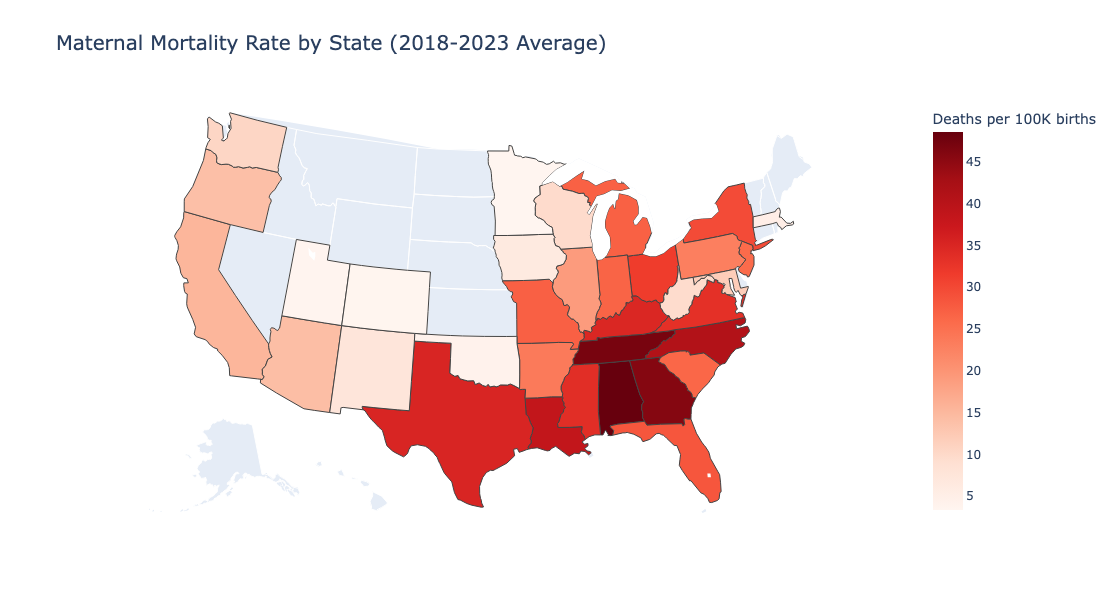


🗺️  Interactive map created!
Hover over states to see details
Dark red = High MMR, Light red = Low MMR


In [11]:
# ============================================================================
# INTERACTIVE STATE CHOROPLETH MAP: Overall MMR (2018-2023)
# ============================================================================

import plotly.express as px

# Prepare data for mapping
map_data = state_mmr_overall[state_mmr_overall['Deaths'] > 0].copy()

# Add state abbreviations for plotly (it needs 2-letter codes)
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'
}

map_data['State_Abbrev'] = map_data['State'].map(state_abbrev)

# Create interactive choropleth map
fig = px.choropleth(
    map_data,
    locations='State_Abbrev',
    locationmode='USA-states',
    color='MMR',
    hover_name='State',
    hover_data={
        'State_Abbrev': False,
        'Deaths': ':,.0f',
        'Births': ':,.0f',
        'MMR': ':.1f'
    },
    color_continuous_scale='Reds',
    scope='usa',
    title='Maternal Mortality Rate by State (2018-2023 Average)',
    labels={'MMR': 'Deaths per 100K births'}
)

fig.update_layout(
    title_font_size=20,
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    ),
    height=600,
    width=1000
)

fig.show()

print("\n🗺️  Interactive map created!")
print("Hover over states to see details")
print("Dark red = High MMR, Light red = Low MMR")

In [12]:
# ============================================================================
# RECOVERY MAP: Percent Change from 2021 Peak to 2023
# ============================================================================

# Prepare recovery data for mapping
recovery_map = state_change_sorted.copy()
recovery_map['State_Abbrev'] = recovery_map['State'].map(state_abbrev)

# Create map showing improvement (negative = good, positive = bad)
fig2 = px.choropleth(
    recovery_map,
    locations='State_Abbrev',
    locationmode='USA-states',
    color='Pct_Change',
    hover_name='State',
    hover_data={
        'State_Abbrev': False,
        'MMR_2021': ':.1f',
        'MMR_2023': ':.1f',
        'Pct_Change': ':.1f%'
    },
    color_continuous_scale='RdYlGn_r',  # Red = got worse, Green = improved
    scope='usa',
    title='State Recovery: Percent Change in MMR (2021 → 2023)',
    labels={'Pct_Change': '% Change'},
    range_color=[-70, 20]  # Scale from -70% (big improvement) to +20% (got worse)
)

fig2.update_layout(
    title_font_size=20,
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    ),
    height=600,
    width=1000
)

fig2.show()

print("\n🗺️  Recovery map created!")
print("Green = Big improvement (good!)")
print("Yellow = Moderate improvement")
print("Red = Small improvement or got worse")


🗺️  Recovery map created!
Green = Big improvement (good!)
Yellow = Moderate improvement
Red = Small improvement or got worse


States with complete 2018-2023 data: 22

✅ Best 5: Wisconsin, Washington, California, Illinois, Pennsylvania
✅ Worst 5: Alabama, Tennessee, Georgia, North Carolina, Louisiana



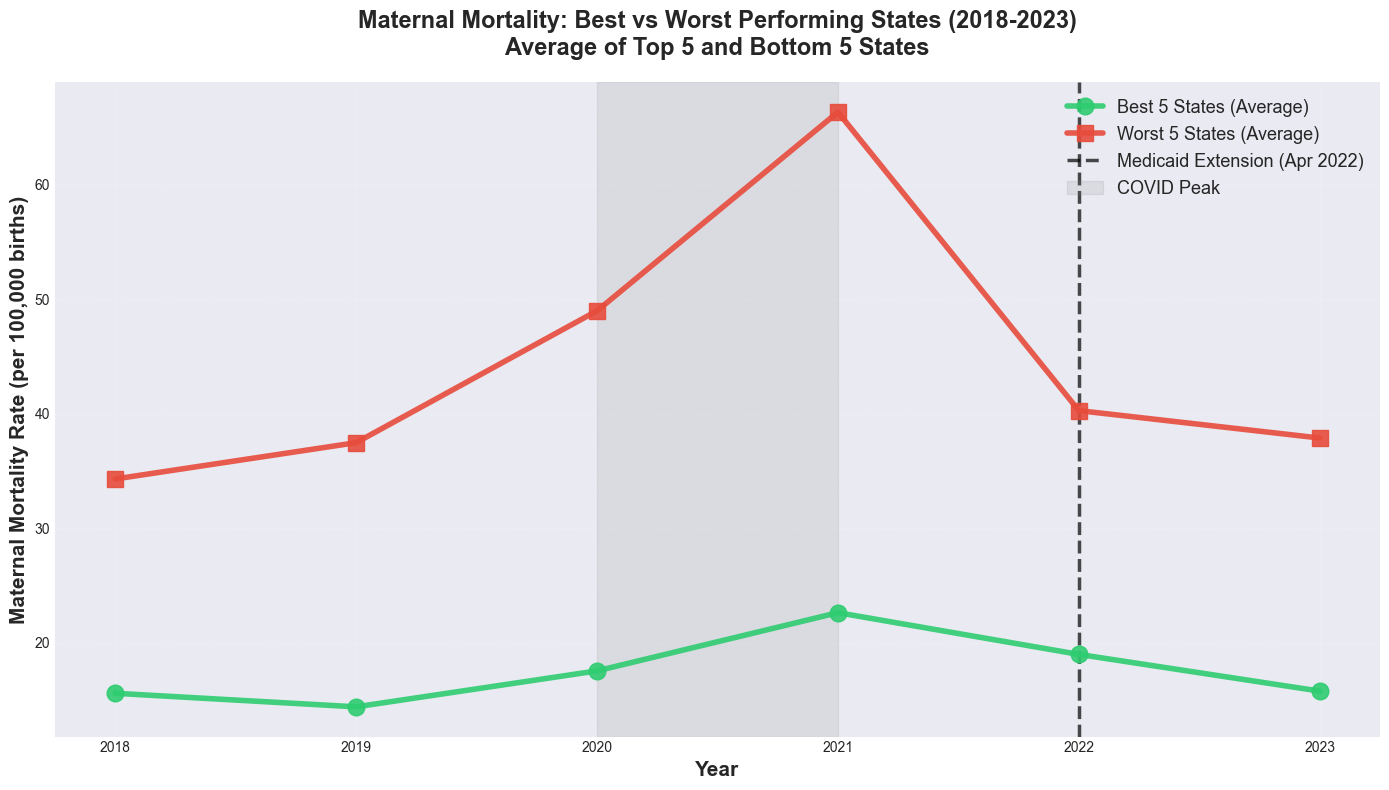


📊 KEY FINDINGS:

🏆 BEST 5 STATES (Average):
  2021 (Peak):      22.6 per 100K
  2023 (Current):   15.8 per 100K
  Change:           -30.3%

⚠️  WORST 5 STATES (Average):
  2021 (Peak):      66.3 per 100K
  2023 (Current):   37.9 per 100K
  Change:           -42.9%

🎯 GAP IN 2023:
  Worst states:     37.9 per 100K
  Best states:      15.8 per 100K
  Difference:       22.1 per 100K (2.4x)


In [13]:
# ============================================================================
# TEMPORAL TRENDS: Best vs Worst (Handling Missing Data)
# ============================================================================

# Get states with valid data AND data in 2023
states_with_2023 = state_year_mmr[
    (state_year_mmr['Year'] == 2023) & 
    (state_year_mmr['MMR'] > 0)
]['State'].unique()

# Filter to only states with complete data
valid_complete = state_mmr_overall[
    (state_mmr_overall['Deaths'] > 0) &
    (state_mmr_overall['State'].isin(states_with_2023))
].copy()

print(f"States with complete 2018-2023 data: {len(valid_complete)}")

# Get best and worst from complete data
best_5 = valid_complete.nsmallest(5, 'MMR')['State'].tolist()
worst_5 = valid_complete.nlargest(5, 'MMR')['State'].tolist()

print(f"\n✅ Best 5: {', '.join(best_5)}")
print(f"✅ Worst 5: {', '.join(worst_5)}\n")

# Calculate averages by year
trend_summary = []
for year in [2018, 2019, 2020, 2021, 2022, 2023]:
    # Best states average
    best_data = state_year_mmr[
        (state_year_mmr['State'].isin(best_5)) & 
        (state_year_mmr['Year'] == year) &
        (state_year_mmr['MMR'] > 0)
    ]
    if len(best_data) > 0 and best_data['Births'].sum() > 0:
        best_avg = (best_data['Deaths'].sum() / best_data['Births'].sum()) * 100000
    else:
        best_avg = None
    
    # Worst states average
    worst_data = state_year_mmr[
        (state_year_mmr['State'].isin(worst_5)) & 
        (state_year_mmr['Year'] == year) &
        (state_year_mmr['MMR'] > 0)
    ]
    if len(worst_data) > 0 and worst_data['Births'].sum() > 0:
        worst_avg = (worst_data['Deaths'].sum() / worst_data['Births'].sum()) * 100000
    else:
        worst_avg = None
    
    trend_summary.append({
        'Year': year,
        'Best_5_Avg': best_avg,
        'Worst_5_Avg': worst_avg
    })

trend_df = pd.DataFrame(trend_summary)

# Create plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot best states average (GREEN)
ax.plot(trend_df['Year'], trend_df['Best_5_Avg'], 
        marker='o', linewidth=4, markersize=12,
        color='#2ecc71', label='Best 5 States (Average)', 
        alpha=0.9, zorder=3)

# Plot worst states average (RED)
ax.plot(trend_df['Year'], trend_df['Worst_5_Avg'], 
        marker='s', linewidth=4, markersize=12,
        color='#e74c3c', label='Worst 5 States (Average)', 
        alpha=0.9, zorder=3)

# Add policy line
ax.axvline(x=2022, color='black', linestyle='--', linewidth=2.5, 
           label='Medicaid Extension (Apr 2022)', alpha=0.7, zorder=2)

# Add COVID shading
ax.axvspan(2020, 2021, alpha=0.15, color='gray', label='COVID Peak', zorder=1)

# Styling
ax.set_xlabel('Year', fontsize=15, fontweight='bold')
ax.set_ylabel('Maternal Mortality Rate (per 100,000 births)', fontsize=15, fontweight='bold')
ax.set_title('Maternal Mortality: Best vs Worst Performing States (2018-2023)\nAverage of Top 5 and Bottom 5 States', 
             fontsize=17, fontweight='bold', pad=20)
ax.legend(fontsize=13, loc='upper right', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax.set_xticks([2018, 2019, 2020, 2021, 2022, 2023])

plt.tight_layout()
plt.show()

# Calculate improvement (with null checks)
best_2021 = trend_df[trend_df['Year']==2021]['Best_5_Avg'].values[0]
best_2023 = trend_df[trend_df['Year']==2023]['Best_5_Avg'].values[0]
worst_2021 = trend_df[trend_df['Year']==2021]['Worst_5_Avg'].values[0]
worst_2023 = trend_df[trend_df['Year']==2023]['Worst_5_Avg'].values[0]

print("\n📊 KEY FINDINGS:")
print("="*60)

if not pd.isna(best_2021) and not pd.isna(best_2023):
    best_change = ((best_2023 - best_2021) / best_2021) * 100
    print(f"\n🏆 BEST 5 STATES (Average):")
    print(f"  2021 (Peak):      {best_2021:.1f} per 100K")
    print(f"  2023 (Current):   {best_2023:.1f} per 100K")
    print(f"  Change:           {best_change:+.1f}%")
else:
    print(f"\n🏆 BEST 5 STATES: Some 2023 data suppressed")

if not pd.isna(worst_2021) and not pd.isna(worst_2023):
    worst_change = ((worst_2023 - worst_2021) / worst_2021) * 100
    print(f"\n⚠️  WORST 5 STATES (Average):")
    print(f"  2021 (Peak):      {worst_2021:.1f} per 100K")
    print(f"  2023 (Current):   {worst_2023:.1f} per 100K")
    print(f"  Change:           {worst_change:+.1f}%")

if not pd.isna(best_2023) and not pd.isna(worst_2023):
    print(f"\n🎯 GAP IN 2023:")
    print(f"  Worst states:     {worst_2023:.1f} per 100K")
    print(f"  Best states:      {best_2023:.1f} per 100K")
    print(f"  Difference:       {worst_2023 - best_2023:.1f} per 100K ({worst_2023/best_2023:.1f}x)")

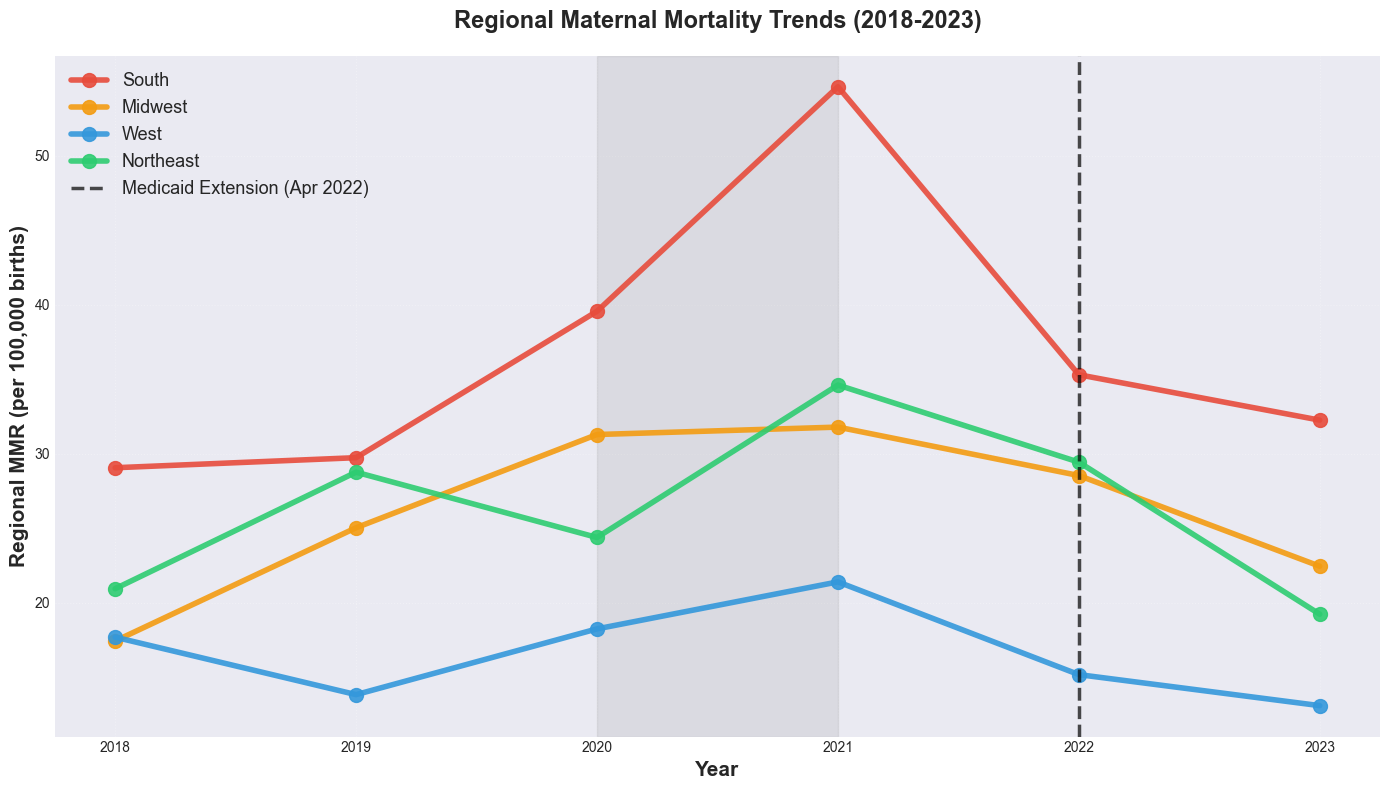


🗺️  REGIONAL ANALYSIS:

South       
  2021:  54.6 per 100K
  2023:  32.3 per 100K
  Change:  -41.0%

Midwest     
  2021:  31.8 per 100K
  2023:  22.5 per 100K
  Change:  -29.4%

West        
  2021:  21.4 per 100K
  2023:  13.1 per 100K
  Change:  -38.8%

Northeast   
  2021:  34.6 per 100K
  2023:  19.2 per 100K
  Change:  -44.4%

🎯 KEY PATTERN:
   South consistently HIGHEST across all years
   Northeast/West consistently LOWER
   All regions improved post-2022, but South remains elevated


In [14]:
# ============================================================================
# REGIONAL ANALYSIS: South vs. Other Regions
# ============================================================================

# Define regions
regions = {
    'South': ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 
              'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina',
              'Tennessee', 'Texas', 'Virginia', 'West Virginia', 'Maryland',
              'Delaware', 'District of Columbia'],
    'West': ['Arizona', 'California', 'Colorado', 'Idaho', 'Montana', 
             'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming',
             'Alaska', 'Hawaii'],
    'Midwest': ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 
                'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 
                'Ohio', 'South Dakota', 'Wisconsin'],
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire',
                  'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island', 'Vermont']
}

# Assign regions
def assign_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Unknown'

state_year_mmr['Region'] = state_year_mmr['State'].apply(assign_region)

# Calculate regional MMR by year (weighted average)
regional_trends = []
for year in [2018, 2019, 2020, 2021, 2022, 2023]:
    for region in ['South', 'West', 'Midwest', 'Northeast']:
        region_data = state_year_mmr[
            (state_year_mmr['Year'] == year) & 
            (state_year_mmr['Region'] == region) &
            (state_year_mmr['MMR'] > 0)
        ]
        
        if len(region_data) > 0 and region_data['Births'].sum() > 0:
            total_deaths = region_data['Deaths'].sum()
            total_births = region_data['Births'].sum()
            regional_mmr = (total_deaths / total_births) * 100000
            
            regional_trends.append({
                'Year': year,
                'Region': region,
                'MMR': regional_mmr,
                'Deaths': total_deaths,
                'Births': total_births
            })

regional_df = pd.DataFrame(regional_trends)

# Create regional plot
fig, ax = plt.subplots(figsize=(14, 8))

region_colors = {
    'South': '#e74c3c',      # Red (worst)
    'Midwest': '#f39c12',    # Orange
    'West': '#3498db',       # Blue (better)
    'Northeast': '#2ecc71'   # Green (best)
}

for region in ['South', 'Midwest', 'West', 'Northeast']:
    region_data = regional_df[regional_df['Region'] == region]
    ax.plot(region_data['Year'], region_data['MMR'], 
            marker='o', linewidth=4, markersize=10,
            label=region, color=region_colors[region], alpha=0.9)

# Add policy line
ax.axvline(x=2022, color='black', linestyle='--', linewidth=2.5, 
           label='Medicaid Extension (Apr 2022)', alpha=0.7)

# Add COVID shading
ax.axvspan(2020, 2021, alpha=0.15, color='gray')

ax.set_xlabel('Year', fontsize=15, fontweight='bold')
ax.set_ylabel('Regional MMR (per 100,000 births)', fontsize=15, fontweight='bold')
ax.set_title('Regional Maternal Mortality Trends (2018-2023)', 
             fontsize=17, fontweight='bold', pad=20)
ax.legend(fontsize=13, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle=':')
ax.set_xticks([2018, 2019, 2020, 2021, 2022, 2023])

plt.tight_layout()
plt.show()

# Regional summary
print("\n🗺️  REGIONAL ANALYSIS:")
print("="*60)

for region in ['South', 'Midwest', 'West', 'Northeast']:
    region_2021 = regional_df[(regional_df['Region']==region) & (regional_df['Year']==2021)]
    region_2023 = regional_df[(regional_df['Region']==region) & (regional_df['Year']==2023)]
    
    if len(region_2021) > 0 and len(region_2023) > 0:
        mmr_2021 = region_2021['MMR'].values[0]
        mmr_2023 = region_2023['MMR'].values[0]
        change = ((mmr_2023 - mmr_2021) / mmr_2021) * 100
        
        print(f"\n{region:12}")
        print(f"  2021: {mmr_2021:5.1f} per 100K")
        print(f"  2023: {mmr_2023:5.1f} per 100K")
        print(f"  Change: {change:+6.1f}%")

print("\n" + "="*60)
print("🎯 KEY PATTERN:")
print("   South consistently HIGHEST across all years")
print("   Northeast/West consistently LOWER")
print("   All regions improved post-2022, but South remains elevated")

In [15]:
# ============================================================================
# SAVE ALL VISUALIZATIONS
# ============================================================================

print("Saving visualizations...")

# We'll need to recreate and save each figure
# For now, let's save the data summaries

# Save regional trends
regional_df.to_csv(f'{base_path}/data/processed/regional_trends_2018_2023.csv', index=False)

# Save best vs worst comparison
trend_df.to_csv(f'{base_path}/data/processed/best_vs_worst_trends.csv', index=False)

print("✅ Data files saved!")
print("\nFiles created:")
print("  - regional_trends_2018_2023.csv")
print("  - best_vs_worst_trends.csv")

print("\n📊 SESSION 2 COMPLETE!")
print("\nKey deliverables:")
print("  ✅ Interactive state maps created")
print("  ✅ Best vs worst trends analyzed")
print("  ✅ Regional patterns identified")
print("  ✅ Publication-quality visualizations")

Saving visualizations...
✅ Data files saved!

Files created:
  - regional_trends_2018_2023.csv
  - best_vs_worst_trends.csv

📊 SESSION 2 COMPLETE!

Key deliverables:
  ✅ Interactive state maps created
  ✅ Best vs worst trends analyzed
  ✅ Regional patterns identified
  ✅ Publication-quality visualizations


In [16]:
# Install kaleido for plotly image export
import sys
!{sys.executable} -m pip install kaleido --break-system-packages

In [17]:
# ============================================================================
# SAVE ALL VISUALIZATIONS AS FILES
# ============================================================================

import os

# Create outputs directory structure
os.makedirs(f'{base_path}/outputs/figures', exist_ok=True)

print("📊 Saving visualizations...")
print("="*60)

# We'll need to recreate each viz and save it
# Let's do them one by one

print("\n1️⃣ Saving interactive state MMR map...")

# Recreate the overall MMR map
map_data = state_mmr_overall[state_mmr_overall['Deaths'] > 0].copy()
map_data['State_Abbrev'] = map_data['State'].map(state_abbrev)

fig1 = px.choropleth(
    map_data,
    locations='State_Abbrev',
    locationmode='USA-states',
    color='MMR',
    hover_name='State',
    hover_data={
        'State_Abbrev': False,
        'Deaths': ':,.0f',
        'Births': ':,.0f',
        'MMR': ':.1f'
    },
    color_continuous_scale='Reds',
    scope='usa',
    title='Maternal Mortality Rate by State (2018-2023 Average)',
    labels={'MMR': 'Deaths per 100K births'}
)

fig1.update_layout(
    title_font_size=20,
    geo=dict(scope='usa', projection=go.layout.geo.Projection(type='albers usa')),
    height=600, width=1000
)

# Save as HTML (interactive) and PNG (static)
fig1.write_html(f'{base_path}/outputs/figures/state_mmr_map_interactive.html')
fig1.write_image(f'{base_path}/outputs/figures/state_mmr_map.png', width=1200, height=700)

print("   ✅ state_mmr_map_interactive.html")
print("   ✅ state_mmr_map.png")

# ============================================================================

print("\n2️⃣ Saving recovery map...")

recovery_map = state_change_sorted.copy()
recovery_map['State_Abbrev'] = recovery_map['State'].map(state_abbrev)

fig2 = px.choropleth(
    recovery_map,
    locations='State_Abbrev',
    locationmode='USA-states',
    color='Pct_Change',
    hover_name='State',
    hover_data={
        'State_Abbrev': False,
        'MMR_2021': ':.1f',
        'MMR_2023': ':.1f',
        'Pct_Change': ':.1f%'
    },
    color_continuous_scale='RdYlGn_r',
    scope='usa',
    title='State Recovery: Percent Change in MMR (2021 → 2023)',
    labels={'Pct_Change': '% Change'},
    range_color=[-70, 20]
)

fig2.update_layout(
    title_font_size=20,
    geo=dict(scope='usa', projection=go.layout.geo.Projection(type='albers usa')),
    height=600, width=1000
)

fig2.write_html(f'{base_path}/outputs/figures/state_recovery_map_interactive.html')
fig2.write_image(f'{base_path}/outputs/figures/state_recovery_map.png', width=1200, height=700)

print("   ✅ state_recovery_map_interactive.html")
print("   ✅ state_recovery_map.png")

# ============================================================================

print("\n3️⃣ Saving best vs worst trends...")

fig3, ax3 = plt.subplots(figsize=(14, 8))

ax3.plot(trend_df['Year'], trend_df['Best_5_Avg'], 
        marker='o', linewidth=4, markersize=12,
        color='#2ecc71', label='Best 5 States (Average)', alpha=0.9)

ax3.plot(trend_df['Year'], trend_df['Worst_5_Avg'], 
        marker='s', linewidth=4, markersize=12,
        color='#e74c3c', label='Worst 5 States (Average)', alpha=0.9)

ax3.axvline(x=2022, color='black', linestyle='--', linewidth=2.5, 
           label='Medicaid Extension (Apr 2022)', alpha=0.7)
ax3.axvspan(2020, 2021, alpha=0.15, color='gray', label='COVID Peak')

ax3.set_xlabel('Year', fontsize=15, fontweight='bold')
ax3.set_ylabel('Maternal Mortality Rate (per 100,000 births)', fontsize=15, fontweight='bold')
ax3.set_title('Maternal Mortality: Best vs Worst Performing States (2018-2023)', 
             fontsize=17, fontweight='bold', pad=20)
ax3.legend(fontsize=13, loc='upper right', framealpha=0.95)
ax3.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax3.set_xticks([2018, 2019, 2020, 2021, 2022, 2023])

plt.tight_layout()
plt.savefig(f'{base_path}/outputs/figures/best_vs_worst_trends.png', dpi=300, bbox_inches='tight')
plt.close()

print("   ✅ best_vs_worst_trends.png")

# ============================================================================

print("\n4️⃣ Saving regional trends...")

fig4, ax4 = plt.subplots(figsize=(14, 8))

region_colors = {
    'South': '#e74c3c',
    'Midwest': '#f39c12',
    'West': '#3498db',
    'Northeast': '#2ecc71'
}

for region in ['South', 'Midwest', 'West', 'Northeast']:
    region_data = regional_df[regional_df['Region'] == region]
    ax4.plot(region_data['Year'], region_data['MMR'], 
            marker='o', linewidth=4, markersize=10,
            label=region, color=region_colors[region], alpha=0.9)

ax4.axvline(x=2022, color='black', linestyle='--', linewidth=2.5, 
           label='Medicaid Extension (Apr 2022)', alpha=0.7)
ax4.axvspan(2020, 2021, alpha=0.15, color='gray')

ax4.set_xlabel('Year', fontsize=15, fontweight='bold')
ax4.set_ylabel('Regional MMR (per 100,000 births)', fontsize=15, fontweight='bold')
ax4.set_title('Regional Maternal Mortality Trends (2018-2023)', 
             fontsize=17, fontweight='bold', pad=20)
ax4.legend(fontsize=13, loc='best', framealpha=0.95)
ax4.grid(True, alpha=0.3, linestyle=':')
ax4.set_xticks([2018, 2019, 2020, 2021, 2022, 2023])

plt.tight_layout()
plt.savefig(f'{base_path}/outputs/figures/regional_trends.png', dpi=300, bbox_inches='tight')
plt.close()

print("   ✅ regional_trends.png")

# ============================================================================

print("\n" + "="*60)
print("✅ ALL VISUALIZATIONS SAVED!")
print("\n📁 Location: outputs/figures/")
print("\nFiles created:")
print("  • state_mmr_map_interactive.html (open in browser)")
print("  • state_mmr_map.png (static image)")
print("  • state_recovery_map_interactive.html")
print("  • state_recovery_map.png")
print("  • best_vs_worst_trends.png")
print("  • regional_trends.png")
print("\n💡 HTML files are interactive - open in browser!")
print("💡 PNG files are publication-quality (300 DPI)")

📊 Saving visualizations...

1️⃣ Saving interactive state MMR map...
   ✅ state_mmr_map_interactive.html
   ✅ state_mmr_map.png

2️⃣ Saving recovery map...
   ✅ state_recovery_map_interactive.html
   ✅ state_recovery_map.png

3️⃣ Saving best vs worst trends...
   ✅ best_vs_worst_trends.png

4️⃣ Saving regional trends...
   ✅ regional_trends.png

✅ ALL VISUALIZATIONS SAVED!

📁 Location: outputs/figures/

Files created:
  • state_mmr_map_interactive.html (open in browser)
  • state_mmr_map.png (static image)
  • state_recovery_map_interactive.html
  • state_recovery_map.png
  • best_vs_worst_trends.png
  • regional_trends.png

💡 HTML files are interactive - open in browser!
💡 PNG files are publication-quality (300 DPI)
